# Udacity Machine Learning Nano Degree 

### Starbucks Capstone Challenge - Training the model

In [1]:
import pandas as pd
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from sagemaker import LinearLearner
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner, CategoricalParameter
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

# Models Implementation

we are going to implement to model XGBoost (xgb) and Lineal Learner to see which one performs better

In [2]:
best_model = {'bogo': {}, 'discount': {}, 'info': {}}

# XGBoost 

In [3]:
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost', '0.90-1')

for prefix in ['bogo', 'discount', 'info']:
    
    xgb = sagemaker.estimator.Estimator(container,
                                        role,
                                        train_instance_count=1,
                                        train_instance_type='ml.c4.xlarge',
                                        output_path=f's3://{bucket}/starbucks_challenge/{prefix}/model',
                                        sagemaker_session=sagemaker_session,
                                        base_job_name=prefix + '-')
    xgb.set_hyperparameters(max_depth=4,
                            eta=0.1,
                            gamma=4,
                            min_child_weight=6,
                            colsample_bytree=0.5,
                            subsample=0.6,
                            early_stopping_rounds=10,
                            num_round=200,
                            seed=1123)

    
    xgb_hyperparameter_tuner = HyperparameterTuner(estimator=xgb,
                                                   objective_metric_name='validation:f1',
                                                   objective_type='Maximize',
                                                   max_jobs=20,
                                                   max_parallel_jobs=4,
                                                   hyperparameter_ranges = {
                                                        'max_depth': IntegerParameter(2, 6),
                                                        'eta'      : ContinuousParameter(0.01, 0.5),
                                                        'gamma': ContinuousParameter(0, 10),
                                                        'min_child_weight': IntegerParameter(2, 8),
                                                        'colsample_bytree': ContinuousParameter(0.2, 1.0),
                                                        'subsample': ContinuousParameter(0.3, 1.0),
                                                   },
                                                   base_tuning_job_name=prefix + '-xgb-tuning')

    
    s3_input_train = sagemaker.s3_input(s3_data=f's3://{bucket}/starbucks_challenge/{prefix}/{prefix}_train.csv', 
                                        content_type='csv')
    s3_input_validation = sagemaker.s3_input(s3_data=f's3://{bucket}/starbucks_challenge/{prefix}/{prefix}_val.csv', 
                                             content_type='csv')

   
    xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})
    
    print(f'Waiting {prefix}...')
    xgb_hyperparameter_tuner.wait()

    # Save results and best model
    best_model[prefix]['xgb'] = {'name': xgb_hyperparameter_tuner.best_training_job(),
                                 'value': xgb_hyperparameter_tuner.analytics().dataframe()['FinalObjectiveValue'].max()}

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


Waiting bogo...
.............................................................................................................................................................................................................................................................!

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


Waiting discount...
...............................................................................................................................................................................................................................................................................!

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.



Waiting info...
...................................................................................................................................................................................................................................................!


Lets re-train with the best model

In [4]:
for prefix in ['bogo', 'discount', 'info']:
    print(prefix)
    
    re_train_model = sagemaker.estimator.Estimator.attach(best_model[prefix]['xgb']['name'])
    
    s3_input_train = sagemaker.s3_input(s3_data=f's3://{bucket}/starbucks_challenge/{prefix}/{prefix}_train.csv', 
                                        content_type='csv')
    s3_input_validation = sagemaker.s3_input(s3_data=f's3://{bucket}/starbucks_challenge/{prefix}/{prefix}_val.csv', 
                                             content_type='csv')

    re_train_model.fit({'train': s3_input_train, 'validation': s3_input_validation})

    best_model[prefix]['xgb']['model'] = re_train_model

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


bogo
2020-08-06 03:04:59 Starting - Preparing the instances for training
2020-08-06 03:04:59 Downloading - Downloading input data
2020-08-06 03:04:59 Training - Training image download completed. Training in progress.
2020-08-06 03:04:59 Uploading - Uploading generated training model
2020-08-06 03:04:59 Completed - Training job completed

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:f1 to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[03:04:49] 14980x15 matrix with 224700 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Determined delimiter of CSV input is ','
[03:04:49] 4280x15 matrix with 64200 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
INFO:root:Single node training.
INFO:root:Setting up HPO optimized metric to be : f1
INFO:root:Train matrix has 14980 rows
INFO:root:Validation matrix has 4280 rows
[0]#0

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


Training seconds: 57
Billable seconds: 57
discount
2020-08-06 03:29:43 Starting - Preparing the instances for training
2020-08-06 03:29:43 Downloading - Downloading input data
2020-08-06 03:29:43 Training - Training image download completed. Training in progress.
2020-08-06 03:29:43 Uploading - Uploading generated training model
2020-08-06 03:29:43 Completed - Training job completed

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:f1 to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[03:29:33] 8692x15 matrix with 130380 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Determined delimiter of CSV input is ','
[03:29:33] 2484x15 matrix with 37260 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
INFO:root:Single node training.
INFO:root:Setting up HPO optimized metric to be : f1
INFO:root:Train matrix has 8692 rows
INFO:root:Validation matrix has 2484 rows
[0]#011

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-08-06 03:54:07 Starting - Preparing the instances for training
2020-08-06 03:54:07 Downloading - Downloading input data
2020-08-06 03:54:07 Training - Training image download completed. Training in progress.
2020-08-06 03:54:07 Uploading - Uploading generated training model
2020-08-06 03:54:07 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:f1 to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[03:53:56] 5087x15 matrix with 76305 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Dete

# Lineal Learner model

Now lest train a lineal learner model.

In [5]:
for prefix in ['bogo', 'discount', 'info']:
    # Create instance of LinearLearner
    linear_learner_model = LinearLearner(role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       predictor_type='binary_classifier',
                       output_path=f's3://{bucket}/starbucks_challenge/{prefix}/model',
                       sagemaker_session=sagemaker_session,
                       binary_classifier_model_selection_criteria='f1',
                       epochs=100,
                       use_bias=True,
                       optimizer='adam',
                       loss='auto',
                       wd=0,
                       normalize_data=True,
                       unbias_data=True,
                       early_stopping_patience=5,
                       learning_rate=0.01,
                       balance_multiclass_weights=True)
    
    # Create record sets from local data as inputs to the LinearLearner
    train = pd.read_csv(f'./data/{prefix}/{prefix}_train.csv', header=None)
    train_data = linear_learner_model.record_set(train.drop(0, 1).values.astype('float32'), 
    labels=train[0].values.astype('float32'),
                                         channel='train')
    
    valid = pd.read_csv(f'./data/{prefix}/{prefix}_train.csv', header=None)
    validation_data = linear_learner_model.record_set(valid.drop(0, 1).values.astype('float32'), 
    labels=valid[0].values.astype('float32'), channel='validation')

    linear_learner_model.fit([train_data, validation_data], logs=False)

    training_job_analytics = linear_learner_model.training_job_analytics
    result_analytics = training_job_analytics.dataframe()
    best_model[prefix]['linear_learner_model'] = {'name': training_job_analytics.name,
                                'value': result_analytics.loc[result_analytics['metric_name'] == \
                                                              'validation:binary_f_beta', 'value'].values[0],
                                'model': linear_learner_model}

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-08-06 04:15:24 Starting - Starting the training job
2020-08-06 04:15:28 Starting - Launching requested ML instances....................
2020-08-06 04:17:12 Starting - Preparing the instances for training................
2020-08-06 04:18:35 Downloading - Downloading input data.
2020-08-06 04:18:48 Training - Downloading the training image...
2020-08-06 04:19:07 Training - Training image download completed. Training in progress..........................
2020-08-06 04:21:19 Uploading - Uploading generated training model.
2020-08-06 04:21:26 Completed - Training job completed

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-08-06 04:21:33 Starting - Starting the training job
2020-08-06 04:21:36 Starting - Launching requested ML instances...................
2020-08-06 04:23:17 Starting - Preparing the instances for training...............
2020-08-06 04:24:36 Downloading - Downloading input data....
2020-08-06 04:25:04 Training - Downloading the training image...
2020-08-06 04:25:24 Training - Training image download completed. Training in progress...................
2020-08-06 04:26:56 Uploading - Uploading generated training model
2020-08-06 04:27:03 Completed - Training job completed

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-08-06 04:27:07 Starting - Starting the training job
2020-08-06 04:27:10 Starting - Launching requested ML instances...................
2020-08-06 04:28:53 Starting - Preparing the instances for training...............
2020-08-06 04:30:12 Downloading - Downloading input data..
2020-08-06 04:30:27 Training - Downloading the training image...
2020-08-06 04:30:46 Training - Training image download completed. Training in progress..............
2020-08-06 04:31:57 Uploading - Uploading generated training model.
2020-08-06 04:32:04 Completed - Training job completed

In [11]:
for prefix in ['bogo', 'discount', 'info']:
    print(f'for {prefix} : ')
    for model_name in ['xgb','linear_learner_model']:
        print('\t\t value {} for {}'.format(best_model[prefix][model_name]['value'], model_name))
    print('\n\n')

for bogo : 
		 value 0.7411620020866394 for xgb
		 value 0.713481285194 for linear_lerner_model



for discount : 
		 value 0.7314689755439758 for xgb
		 value 0.708928902914 for linear_lerner_model



for info : 
		 value 0.6606659889221191 for xgb
		 value 0.691518566681 for linear_lerner_model





For `bogo` and for `discount` xgb model performs better, and for `info` linear_learner performs better than xgb

In [14]:
for prefix in ['bogo','discount', 'info']:
    print(prefix)

    # Create lineal learner transformer
    model_transform = best_model[prefix]['linear_learner_model']['model'].transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

    model_transform.transform(f's3://{bucket}/starbucks_challenge/{prefix}/{prefix}_test.csv',
                                       content_type='text/csv', split_type='Line', logs=False)
    
    model_transform.wait(logs=False)
    
    sagemaker_session.download_data(f'./data/{prefix}/{prefix}_linear_learner_model_preds', bucket,
                          key_prefix='/'.join(model_transform.output_path.split('/')[3:]))
    
    # Create xgb transformer
    model_transform = best_model[prefix]['xgb']['model'].transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

    model_transform.transform(f's3://{bucket}/starbucks_challenge/{prefix}/{prefix}_test.csv',
                                       content_type='text/csv', split_type='Line', wait=True, logs=False)

    sagemaker_session.download_data(f'./data/{prefix}/{prefix}_xgb_preds', bucket,
                          key_prefix='/'.join(model_transform.output_path.split('/')[3:]))

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


bogo
...................................................!

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.



...................................................!

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.



discount
......................................................!


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


.................................................!

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.



info
.................................................!


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


....................................................!


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, \
    precision_score, recall_score, f1_score, average_precision_score, \
    roc_auc_score, roc_curve

def analyze_visualize_model(y, y_prob, y_pred=None):

    if y_pred is None:
        y_pred = pd.Series([1 if x >= 0.5 else 0 for x in y_prob])
        
    result = pd.DataFrame(
        {'value': [accuracy_score(y, y_pred),
                   balanced_accuracy_score(y, y_pred),
                   precision_score(y, y_pred), recall_score(y, y_pred),
                   f1_score(y, y_pred),
                   average_precision_score(y, y_prob),
                   roc_auc_score(y, y_prob)]
         },
        index=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1',
               'average_precision', 'AUC']
    )

    fpr, tpr, _ = roc_curve(y, y_prob)
    plt.plot(fpr, tpr)
    plt.show()

    display(pd.crosstab(y, y_pred, normalize='index'))

    return result

bogo
XGBoost predictions


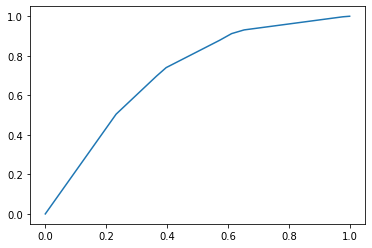

col_0,0,1
0,,
0.0,0.602804,0.397196
1.0,0.259813,0.740187


,value
accuracy,0.671495
balanced_accuracy,0.671495
precision,0.650781
recall,0.740187
f1,0.692610
average_precision,0.649445
AUC,0.711577





bogo
LinearLearner predictions


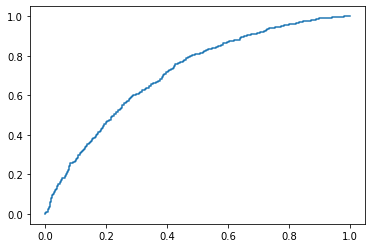

col_0,0,1
0,,
0.0,0.417757,0.582243
1.0,0.142056,0.857944


,value
accuracy,0.637850
balanced_accuracy,0.637850
precision,0.595717
recall,0.857944
f1,0.703179
average_precision,0.680886
AUC,0.712177






discount
XGBoost predictions


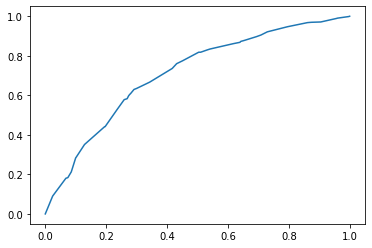

col_0,0,1
0,,
0.0,0.708535,0.291465
1.0,0.370370,0.629630


,value
accuracy,0.669082
balanced_accuracy,0.669082
precision,0.683566
recall,0.629630
f1,0.655490
average_precision,0.674997
AUC,0.710184





discount
LinearLearner predictions


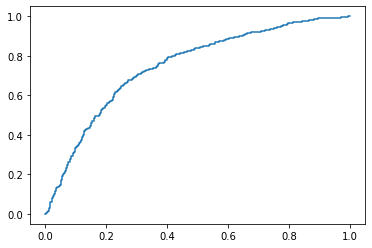

col_0,0,1
0,,
0.0,0.439614,0.560386
1.0,0.132045,0.867955


,value
accuracy,0.653784
balanced_accuracy,0.653784
precision,0.607666
recall,0.867955
f1,0.714854
average_precision,0.706193
AUC,0.747288






info
XGBoost predictions


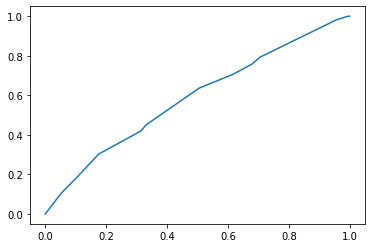

col_0,0,1
0,,
0.0,0.667582,0.332418
1.0,0.548209,0.451791


,value
accuracy,0.559835
balanced_accuracy,0.559687
precision,0.575439
recall,0.451791
f1,0.506173
average_precision,0.572414
AUC,0.586603





info
LinearLearner predictions


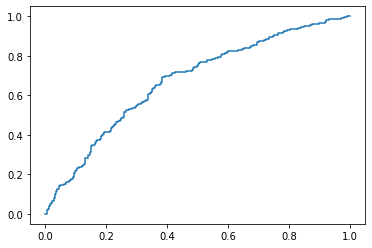

col_0,0,1
0,,
0.0,0.192308,0.807692
1.0,0.066116,0.933884


,value
accuracy,0.562586
balanced_accuracy,0.563096
precision,0.535545
recall,0.933884
f1,0.680723
average_precision,0.642065
AUC,0.671124


In [19]:
import json

for prefix in ['bogo', 'discount', 'info']:
    print(prefix)
    y_test = pd.read_csv(f'./data/{prefix}/{prefix}_test_target.csv', squeeze=True, header=None)
    
    print('XGBoost predictions')
    y_prob = pd.read_csv(f'./data/{prefix}/{prefix}_xgb_preds/{prefix}_test.csv.out', squeeze=True, header=None)
    display(analyze_visualize_model(y_test, y_prob))
      
    print('\n\n')
    print(prefix)
    print('LinearLearner predictions')
    with open(f'./data/{prefix}/{prefix}_linear_learner_model_preds/{prefix}_test.csv.out', 'r') as test_file:
        jsons = [json.loads(x.replace('\n', '')) for x in test_file.readlines()]
    res = pd.DataFrame(jsons)
    display(analyze_visualize_model(y_test, res['score'].values, y_pred=res['predicted_label'].values))
      
    print('\n\n\n')

For `bogo` and `discount` xgb model performs better than linear_learner, and for `info` linear_learner performs better than xgb

In [ ]:
!tar chvfz project.tar.gz *